In [3]:
%matplotlib inline
import scipy.io
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from wide_resnet import WideResNet


os.environ["CUDA_VISIBLE_DEVICES"]="2,3"
# load model and weights
img_size64 = 64
model64 = WideResNet(img_size64, depth=22, k=8)()
model64.load_weights(os.path.join("../../dataset/checkpoints", "model64.hdf5"))

img_size32 = 32
model32 = WideResNet(img_size32, depth=16, k=8)()
model32.load_weights(os.path.join("../../dataset/checkpoints", "model32.hdf5"))


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


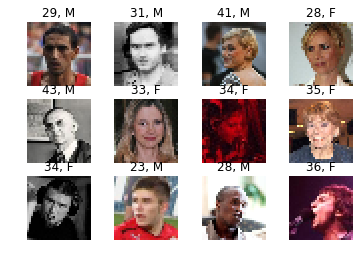

In [8]:
db = "wiki"
data = scipy.io.loadmat(os.path.join("../../dataset/", "{}32.mat".format(db)))
test_images = data["image"]
test_genders = data["gender"][0]
test_ages = data["age"][0]

cols, rows = 4, 3
img_num = cols * rows
path_root = "data/{}_crop/".format(db)
img_ids = np.random.choice(len(test_ages), img_num)
sub_test_images = test_images[img_ids,:,:,:]

# predict
results = model32.predict(sub_test_images)
predicted_genders = results[0]
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages = results[1].dot(ages).flatten()

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(sub_test_images[i,:,:,:], cv2.COLOR_BGR2RGB))
    plt.title("{}, {}".format(int(predicted_ages[i]),
                              "F" if predicted_genders[i][0]>0.5 else "M"))
    plt.axis('off')
plt.savefig("result.png")

Age baby.jpg (32x32):  41
Gender baby.jpg (32x32):  M
Age baby.jpg (64x64):  31
Gender baby.jpg (64x64):  F
Age katy.jpg (32x32):  33
Gender katy.jpg (32x32):  F
Age katy.jpg (64x64):  28
Gender katy.jpg (64x64):  F
Age tom.jpg (32x32):  37
Gender tom.jpg (32x32):  M
Age tom.jpg (64x64):  31
Gender tom.jpg (64x64):  M
Age women_old.jpg (32x32):  39
Gender women_old.jpg (32x32):  M
Age women_old.jpg (64x64):  34
Gender women_old.jpg (64x64):  M
Age floyd.jpg (32x32):  34
Gender floyd.jpg (32x32):  M
Age floyd.jpg (64x64):  38
Gender floyd.jpg (64x64):  M
Age conor.jpg (32x32):  37
Gender conor.jpg (32x32):  M
Age conor.jpg (64x64):  47
Gender conor.jpg (64x64):  M
Age nav.jpg (32x32):  43
Gender nav.jpg (32x32):  M
Age nav.jpg (64x64):  35
Gender nav.jpg (64x64):  M
Age old.jpg (32x32):  58
Gender old.jpg (32x32):  M
Age old.jpg (64x64):  50
Gender old.jpg (64x64):  M


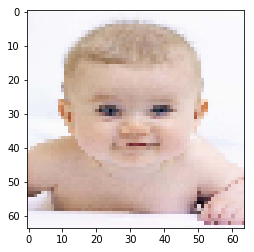

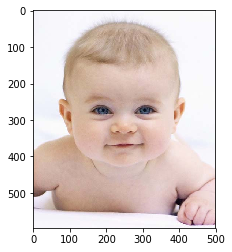

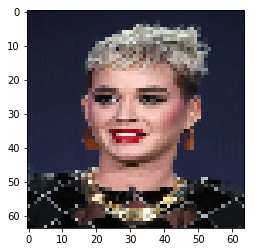

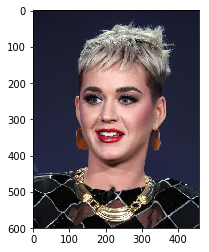

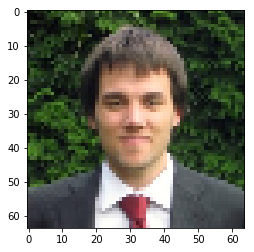

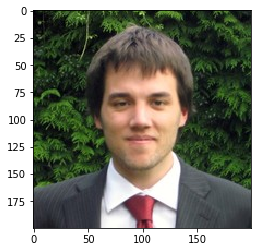

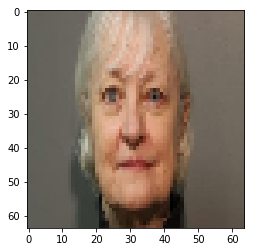

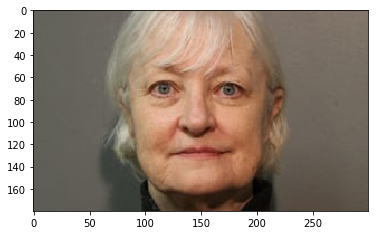

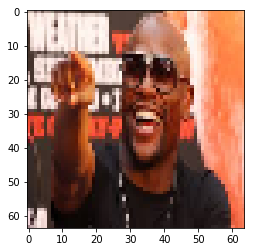

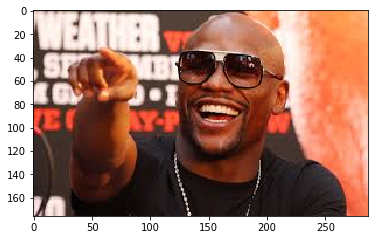

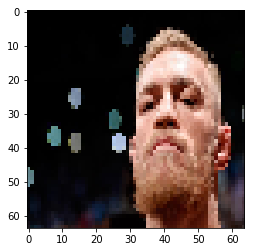

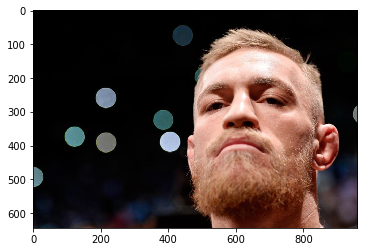

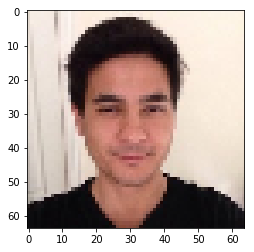

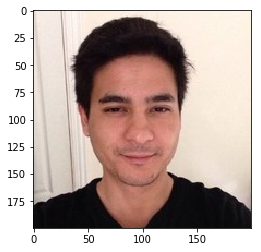

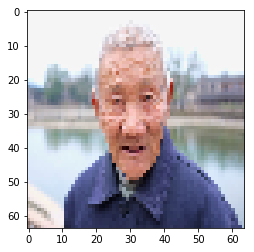

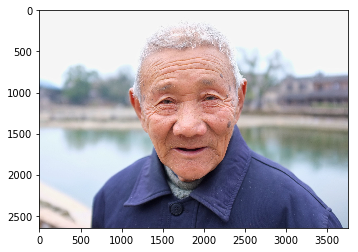

In [7]:
from os import listdir
from os.path import isfile, join

mypath='test/'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images32 = np.empty(len(onlyfiles), dtype=object)
faces32 = np.empty((len(onlyfiles), img_size32, img_size32, 3))
images64 = np.empty(len(onlyfiles), dtype=object)
faces64 = np.empty((len(onlyfiles), img_size64, img_size64, 3))
for n in range(0, len(onlyfiles)):
    images32[n] = cv2.imread( join(mypath,onlyfiles[n]))
    images32[n] = cv2.cvtColor(images32[n],cv2.COLOR_BGR2RGB)
    faces32[n, : , : , :] = cv2.resize(images32[n][35:-35,35:-35,:], (img_size32, img_size32))
    
    images64[n] = cv2.imread( join(mypath,onlyfiles[n]))
    images64[n] = cv2.cvtColor(images64[n],cv2.COLOR_BGR2RGB)
    faces64[n, : , : , :] = cv2.resize(images64[n][35:-35,35:-35,:], (img_size64, img_size64))
    
results32 = model32.predict(faces32)
results64 = model64.predict(faces64)
predicted_genders32 = results32[0]
predicted_genders64 = results64[0]
ages = np.arange(0, 101).reshape(101, 1)
predicted_ages32 = results32[1].dot(ages).flatten()
predicted_ages64 = results64[1].dot(ages).flatten()

for n in range(len(onlyfiles)):
    plt.figure()
    plt.imshow(cv2.resize(images32[n], (img_size64, img_size64)))
    print("Age " +onlyfiles[n]+ " (32x32): ", int(predicted_ages32[n]))
    print("Gender " +onlyfiles[n]+ " (32x32): ", "F" if predicted_genders32[n][0] > 0.5 else "M")
    plt.figure()
    plt.imshow(images64[n])
    print("Age " +onlyfiles[n]+ " (64x64): ", int(predicted_ages64[n]))
    print("Gender " +onlyfiles[n]+ " (64x64): ", "F" if predicted_genders64[n][0] > 0.5 else "M")